In [194]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import TensorBoard
import os
import numpy as np

In [195]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [196]:
# Remove dodgy images
import cv2
import imghdr
from matplotlib import pyplot as plt

In [197]:
# Directory where your data is stored
data_dir = 'data'
os.listdir(os.path.join(data_dir))
# Loading data and preprocessing
# data = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,  # Splitting data into train and validation
#     subset="training",
#     seed=42,
#     image_size=(256, 256),  # Resizing images to the desired size
#     batch_size=32  # Batch size for training
# )

['happy', 'sad']

In [198]:
image_exts = ['jpeg', 'png', 'jpg', 'bmp', 'gif']

In [199]:
img = cv2.imread(os.path.join(data_dir, "happy", "05-12-21-happy-people.jpg"))

In [200]:
img.shape

(880, 1400, 3)

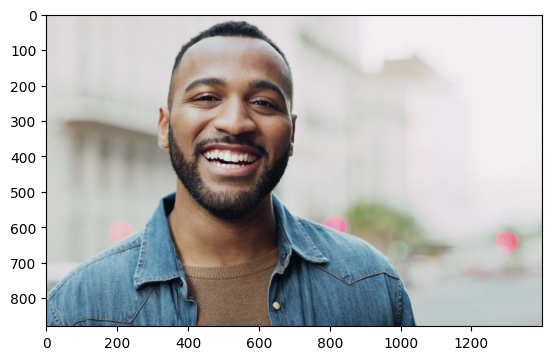

In [201]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [202]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list: " + image_path)
                os.remove(image_path)
        except Exception as e:
            print('Issue with image:'+ image_path)

In [203]:
# Loading data
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [204]:
# data = tf.keras.utils.image_dataset_from_directory('data')
# Loading data and preprocessing
data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Splitting data into train and validation
    subset="training",
    seed=42,
    image_size=(256, 256),  # Resizing images to the desired size
    batch_size=32  # Batch size for training
)

Found 155 files belonging to 2 classes.


Using 124 files for training.


In [205]:
data_iterator = data.as_numpy_iterator()

In [206]:
# Get another batch from the iterator
batch = data_iterator.next()

In [207]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [208]:
# Class 1 = Sad People
# Class 0 = Happy People
batch[1]

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0])

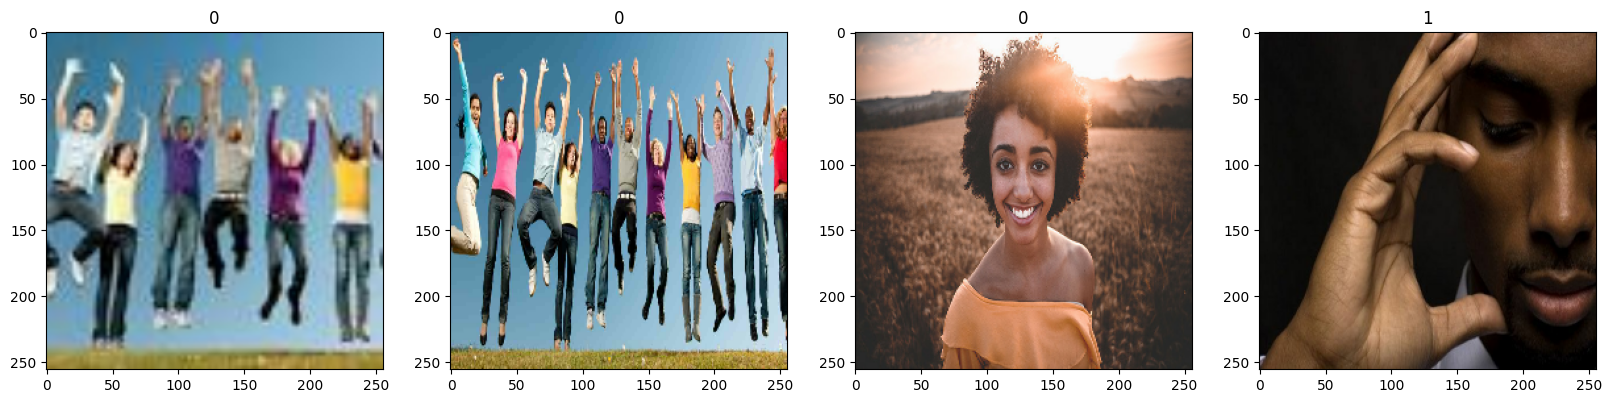

In [209]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


In [210]:
# Preprocessing data

# Scaling our data
# x = independent variable
# y = dependent/target variable
data = data.map(lambda x, y: (x/255, y))

In [211]:
scaled_iterator = data.as_numpy_iterator()

In [212]:
batch = scaled_iterator.next()

In [213]:
batch[0].max()

1.0

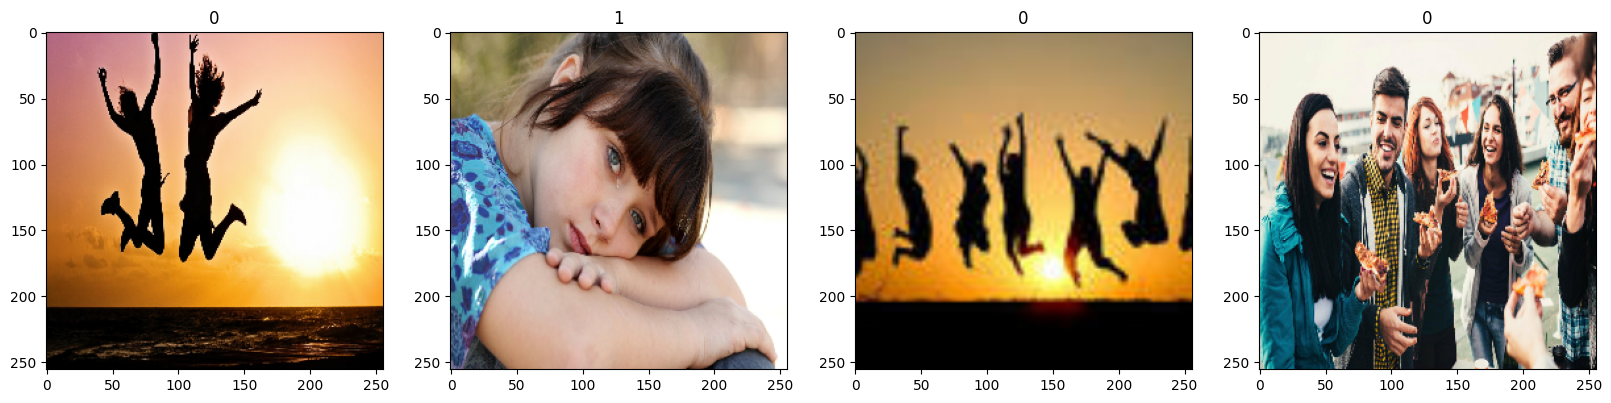

In [214]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [215]:
# Spit Data to train and test set
len(data)

4

In [216]:
train_size = int(len(data) * 0.7)
validation_size = int(len(data) * 0.2)+1
test_size = int(len(data) * 0.1)+1

In [217]:
train_size*validation_size*test_size

2

In [218]:
train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size).take(test_size)

In [219]:
len(test)

1

In [220]:
# Defining the model architecture
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 16)       

In [221]:
# Train the model
tensorboard_callback = TensorBoard(log_dir='./logs')
hist = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20


2/2 [==============================] - 16s 6s/step - loss: 0.8838 - accuracy: 0.6875 - val_loss: 0.5773 - val_accuracy: 0.6875
Epoch 2/20
2/2 [==============================] - 14s 7s/step - loss: 0.6111 - accuracy: 0.7188 - val_loss: 0.6737 - val_accuracy: 0.6562
Epoch 3/20
2/2 [==============================] - 9s 5s/step - loss: 0.6464 - accuracy: 0.5625 - val_loss: 0.5002 - val_accuracy: 0.6875
Epoch 4/20
2/2 [==============================] - 8s 5s/step - loss: 0.5578 - accuracy: 0.6875 - val_loss: 0.5548 - val_accuracy: 0.6562
Epoch 5/20
2/2 [==============================] - 10s 5s/step - loss: 0.5565 - accuracy: 0.6406 - val_loss: 0.4987 - val_accuracy: 0.7812
Epoch 6/20
2/2 [==============================] - 9s 5s/step - loss: 0.5374 - accuracy: 0.7812 - val_loss: 0.4442 - val_accuracy: 0.8750
Epoch 7/20
2/2 [==============================] - 10s 6s/step - loss: 0.4287 - accuracy: 0.7656 - val_loss: 0.6441 - val_accuracy: 0.5938
Epoch 8/20
2/2 [==============================] 

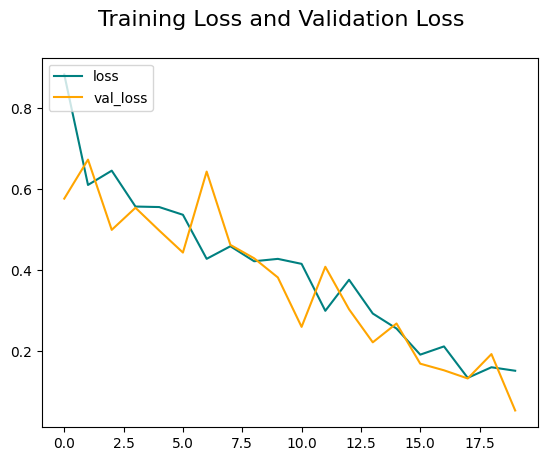

In [222]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Training Loss and Validation Loss', fontsize=16)
plt.legend(loc="upper left")
plt.show()

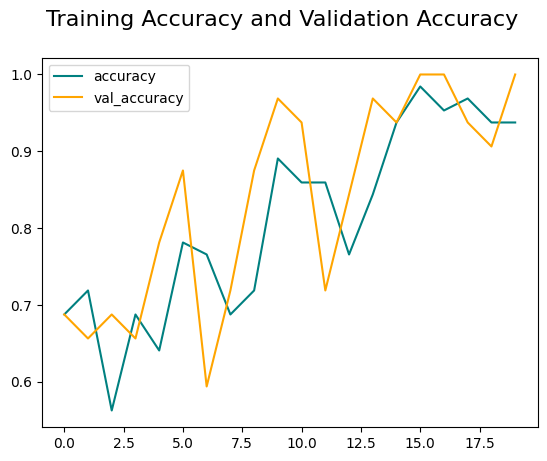

In [223]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Training Accuracy and Validation Accuracy', fontsize=16)
plt.legend(loc="upper left")
plt.show()

In [224]:
# Evaluate Performance
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [225]:
for batch in test:
    x, y = batch
    yhat = model.predict(x)
    
    # Debugging: Print intermediate values
    print(f"y: {y}")
    print(f"yhat: {yhat}")
    
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


1/1 [==============================] - 1s 943ms/step
y: [1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0]
yhat: [[5.3006983e-01]
 [1.5122606e-01]
 [1.2786622e-01]
 [9.9292350e-01]
 [8.5592484e-01]
 [4.0163800e-02]
 [6.9449493e-03]
 [2.2034948e-03]
 [9.6047938e-01]
 [8.8815385e-01]
 [9.9227273e-01]
 [1.0596644e-02]
 [9.8863268e-01]
 [6.7086862e-06]
 [4.6542265e-02]
 [5.7752203e-04]
 [1.9374158e-02]
 [8.2141198e-03]
 [9.1208035e-01]
 [9.6273088e-01]
 [1.6335369e-03]
 [3.2703197e-01]
 [3.0847921e-04]
 [9.9723947e-01]
 [7.5856370e-01]
 [9.2264396e-01]
 [1.9084130e-03]
 [5.5035762e-03]]


In [227]:
# Print evaluation results
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


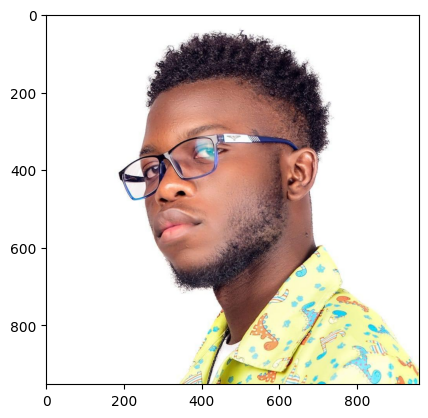

In [250]:
img = cv2.imread('james.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

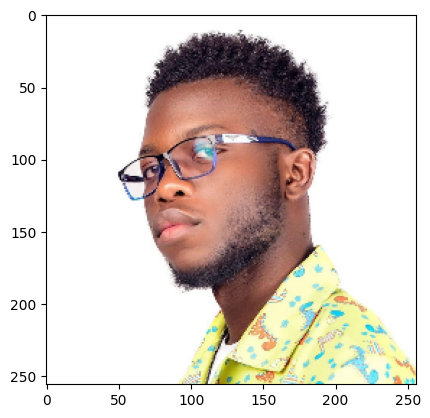

In [252]:
resize = tf.image.resize(img, (256,256))
plt.imshow(cv2.cvtColor(resize.numpy().astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()


In [253]:
resize.shape

TensorShape([256, 256, 3])

In [254]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 406ms/step


In [255]:
yhat

array([[0.92014235]], dtype=float32)

In [256]:
if yhat > 0.5:
    print(f"Predicted class is Sad")
else:
    print(f"Predicted class is Happy")

Predicted class is Sad


In [257]:
from tensorflow.keras.models import load_model

In [258]:
model.save(os.path.join('models','happysadmodel.h5'))

c:\Users\izah_\Documents\image-classification\myenv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [259]:
new_model = load_model(os.path.join('models', 'happysadmodel.h5'))

In [260]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 441ms/step


In [261]:
if yhat_new > 0.5:
    print(f"Predicted class is Sad")
else:
    print(f"Predicted class is Happy")

Predicted class is Sad
